In [242]:
# visualisation
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#operating system and subprocess
import os
import sys
import subprocess

# Data Cleaning
1) Analyse raw data (shapes, null values, dtypes of each column, etc)
2) Conduct outlier analysis
3) Check and remove any duplicated data
4) Conduct categorical analysis (ensure values that are referring to the same items have the same value (e.g. abbreviations are generalised))
5) Other data cleaning required activities according to datasets

## Loading CSV file

In [243]:
# AI processed dataset path
INFECTIOUS_DISEASE_AI_DATA_DIR = "../../data/3_interim/cleaned_disease_data.parquet"
# original dataset path

INFECTIOUS_DISEASE_DATA_DIR = "../datasets/weekly-infectious-disease-bulletin-cases.csv"

In [244]:
# reading the respective files
AI_df = pl.read_parquet(INFECTIOUS_DISEASE_AI_DATA_DIR)
df = pl.read_csv(INFECTIOUS_DISEASE_DATA_DIR)
print(df.head())

shape: (5, 3)
┌──────────┬─────────────────────────┬──────────────┐
│ epi_week ┆ disease                 ┆ no._of_cases │
│ ---      ┆ ---                     ┆ ---          │
│ str      ┆ str                     ┆ i64          │
╞══════════╪═════════════════════════╪══════════════╡
│ 2012-W01 ┆ Acute Viral hepatitis B ┆ 0            │
│ 2012-W01 ┆ Acute Viral hepatitis C ┆ 0            │
│ 2012-W01 ┆ Avian Influenza         ┆ 0            │
│ 2012-W01 ┆ Campylobacterenterosis  ┆ 6            │
│ 2012-W01 ┆ Chikungunya Fever       ┆ 0            │
└──────────┴─────────────────────────┴──────────────┘


In [245]:
def describe(df, name=""):
    """
    Function is to understand about df structure, null values, datatypes
    Args: 
        df: pandas dataframe
    Returns:
        None
    """
    print(f"Analyzing dataframe {name}")
    print("Dataframe rows x cols:", df.shape, "\nDataframe Description:\n", df.describe())
    print("\tDataframe dtypes:", df.dtypes)

In [246]:
describe(df)

Analyzing dataframe 
Dataframe rows x cols: (16066, 3) 
Dataframe Description:
 shape: (9, 4)
┌────────────┬──────────┬─────────────────────────┬──────────────┐
│ describe   ┆ epi_week ┆ disease                 ┆ no._of_cases │
│ ---        ┆ ---      ┆ ---                     ┆ ---          │
│ str        ┆ str      ┆ str                     ┆ f64          │
╞════════════╪══════════╪═════════════════════════╪══════════════╡
│ count      ┆ 16066    ┆ 16066                   ┆ 16066.0      │
│ null_count ┆ 0        ┆ 0                       ┆ 0.0          │
│ mean       ┆ null     ┆ null                    ┆ 24.650255    │
│ std        ┆ null     ┆ null                    ┆ 121.676852   │
│ min        ┆ 2012-W01 ┆ Acute Viral Hepatitis A ┆ 0.0          │
│ 25%        ┆ null     ┆ null                    ┆ 0.0          │
│ 50%        ┆ null     ┆ null                    ┆ 0.0          │
│ 75%        ┆ null     ┆ null                    ┆ 2.0          │
│ max        ┆ 2020-W53 ┆ Zika Viru

#### Check for outliers

In [247]:
def get_outliers(df: pl.DataFrame, col: str) -> pl.DataFrame:
    """
    Function to get outliers in a given column using IQR method
    Args:
        pl: polars dataframe
        col: column name to check for outliers
    Outputs:
        pl.DataFrame with outliers
    """
    print("\n----Checking outliers for column:---\n", col)
    q1 = df[col].quantile(0.25) # get the first quartile
    q3 = df[col].quantile(0.75) # get the third quartile
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df.filter((df[col] < lower_bound) | (df[col] > upper_bound)) #filter out the outliers
    print(f"Number of outliers in {col}: ", outliers.height)
    # plot boxplot 
    fig = plt.figure(figsize=(10, 5))
    plt.boxplot(df[col])
    plt.show()

    return outliers

#### Check Duplicates

In [248]:
def check_duplicates(df: pl.DataFrame) -> pl.DataFrame:
    """
    Function to check and drop complete duplicate rows (means all columns values are the same)
    Args:
        df: polars dataframe
    Outputs:
        df_without_duplicates : pl.DataFrame without duplicated rows
    """
    # get duplcated rows
    duplicate_rows = df.filter(df.is_duplicated())
    print("Duplicated Rows:\n", duplicate_rows, "Number of Duplicates", len(duplicate_rows) )

    df_without_duplicates = df.unique()

    print("\nDataframe shape without duplicates:\n", df_without_duplicates.shape, "/% of Rows dropped:", (df.shape[0] - df_without_duplicates.shape[0]) / df.shape[0])
    return df_without_duplicates

#### Check Categorical Data

In [249]:
def check_categorical_values(df: pl.DataFrame, col: str) -> pl.DataFrame:
    """
    Function to check accuracy of categorical variables (e.g. typos, value count, etc)
    Args: 
        df: polars dataframe
        cols: list[str] of categorical columns' name to check
    Outputs:
        None
        - prints unique values for specified columns
        - prints for value counts for specified columns
    """
    print(f"\n=== Processing column: {col} ===\n")
    selected_col = df[col]

    # unique rows
    unique_val = selected_col.unique().to_list()
    print(f"Total number of unique diseases: {len(unique_val)}\n")
    print("All unique diseases:")
    unique_val.sort()
    for i, val in enumerate(unique_val, 1):
        print(f"{i}. {val}")

    # value counts
    print("\nValue counts:\n", selected_col.value_counts()) 
    value_count_col = selected_col.value_counts().to_dict()
    print("\nValue counts dict:\n", value_count_col)
    return

## Understanding Dataframe 

In [250]:
def check_df_val(df:pl.DataFrame) -> pl.DataFrame:
    """
    Function to understand Dataframe values (such as outliers, duplicates, categorical values)
    Args:
        df: polars dataframe
    Outputs:
        df = pl.DataFrame (cleaned file)
        - prints outlier analysis for numerical columns
        - prints any duplicates row
        - categorical value analysis
    """
    print("\n---Checking Duplicates---\n")
    df_no_duplicates = check_duplicates(df)

    numerical_dataframe = df_no_duplicates.select(pl.selectors.numeric())
    categorical_dataframe = df_no_duplicates.select(pl.selectors.string())
    print("---Numerical Columns Analysis---")
    for col in numerical_dataframe.columns:
        print(f"=== Processing column: {col} ===")
        outliers = get_outliers(numerical_dataframe, col)

    print("\n---Categorical Columns Analysis---\n")
    for col in categorical_dataframe.columns:
        print(f"\n=== Processing column: {col} ===\n")
        check_categorical_values(categorical_dataframe, col)
        df_no_duplicates = df_no_duplicates.with_columns(
            pl.col(col).str.strip().alias(col)
        )
    return df_no_duplicates



---Checking Duplicates---

Duplicated Rows:
 shape: (0, 3)
┌──────────┬─────────┬──────────────┐
│ epi_week ┆ disease ┆ no._of_cases │
│ ---      ┆ ---     ┆ ---          │
│ str      ┆ str     ┆ i64          │
╞══════════╪═════════╪══════════════╡
└──────────┴─────────┴──────────────┘ Number of Duplicates 0

Dataframe shape without duplicates:
 (16066, 3) /% of Rows dropped: 0.0
---Numerical Columns Analysis---
=== Processing column: no._of_cases ===

----Checking outliers for column:---
 no._of_cases
Number of outliers in no._of_cases:  2220


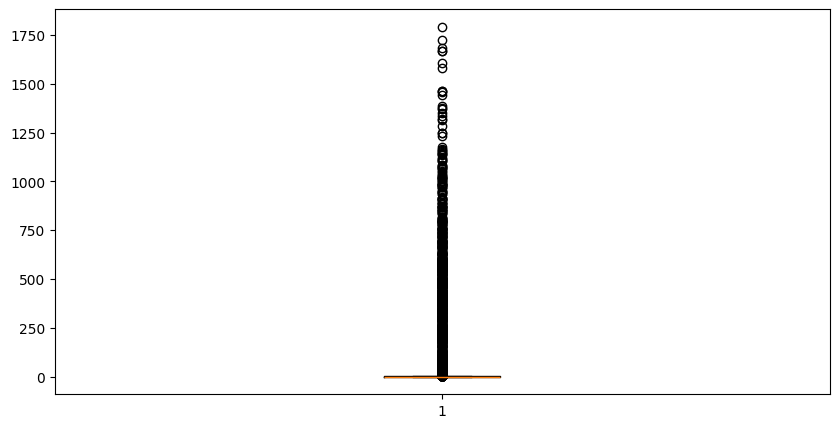


---Categorical Columns Analysis---


=== Processing column: epi_week ===


=== Processing column: epi_week ===

Total number of unique diseases: 470

All unique diseases:
1. 2012-W01
2. 2012-W02
3. 2012-W03
4. 2012-W04
5. 2012-W05
6. 2012-W06
7. 2012-W07
8. 2012-W08
9. 2012-W09
10. 2012-W10
11. 2012-W11
12. 2012-W12
13. 2012-W13
14. 2012-W14
15. 2012-W15
16. 2012-W16
17. 2012-W17
18. 2012-W18
19. 2012-W19
20. 2012-W20
21. 2012-W21
22. 2012-W22
23. 2012-W23
24. 2012-W24
25. 2012-W25
26. 2012-W26
27. 2012-W27
28. 2012-W28
29. 2012-W29
30. 2012-W30
31. 2012-W31
32. 2012-W32
33. 2012-W33
34. 2012-W34
35. 2012-W35
36. 2012-W36
37. 2012-W37
38. 2012-W38
39. 2012-W39
40. 2012-W40
41. 2012-W41
42. 2012-W42
43. 2012-W43
44. 2012-W44
45. 2012-W45
46. 2012-W46
47. 2012-W47
48. 2012-W48
49. 2012-W49
50. 2012-W50
51. 2012-W51
52. 2012-W52
53. 2013-W01
54. 2013-W02
55. 2013-W03
56. 2013-W04
57. 2013-W05
58. 2013-W06
59. 2013-W07
60. 2013-W08
61. 2013-W09
62. 2013-W10
63. 2013-W11
64. 2013-W12
65. 2

In [251]:
# check original dataset
df_no_duplicates = check_df_val(df)


---Checking Duplicates---

Duplicated Rows:
 shape: (0, 10)
┌─────────────┬──────┬──────┬─────────────┬───┬────────────┬────────────┬─────────────┬────────────┐
│ epidemiolog ┆ year ┆ week ┆ week_start_ ┆ … ┆ case_count ┆ is_outlier ┆ transmissio ┆ burden_tie │
│ ical_week   ┆ ---  ┆ ---  ┆ date        ┆   ┆ ---        ┆ ---        ┆ n_mode      ┆ r          │
│ ---         ┆ i32  ┆ i32  ┆ ---         ┆   ┆ i64        ┆ bool       ┆ ---         ┆ ---        │
│ str         ┆      ┆      ┆ date        ┆   ┆            ┆            ┆ str         ┆ str        │
╞═════════════╪══════╪══════╪═════════════╪═══╪════════════╪════════════╪═════════════╪════════════╡
└─────────────┴──────┴──────┴─────────────┴───┴────────────┴────────────┴─────────────┴────────────┘ Number of Duplicates 0

Dataframe shape without duplicates:
 (16066, 10) /% of Rows dropped: 0.0
---Numerical Columns Analysis---
=== Processing column: year ===

----Checking outliers for column:---
 year
Number of outliers in year

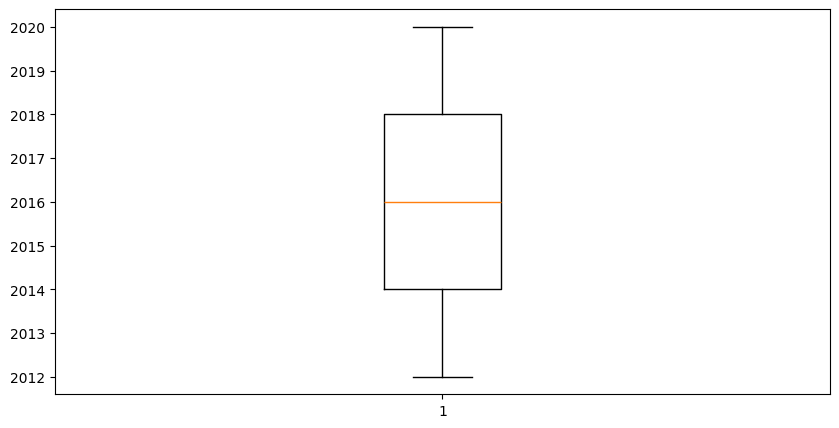

=== Processing column: week ===

----Checking outliers for column:---
 week
Number of outliers in week:  0


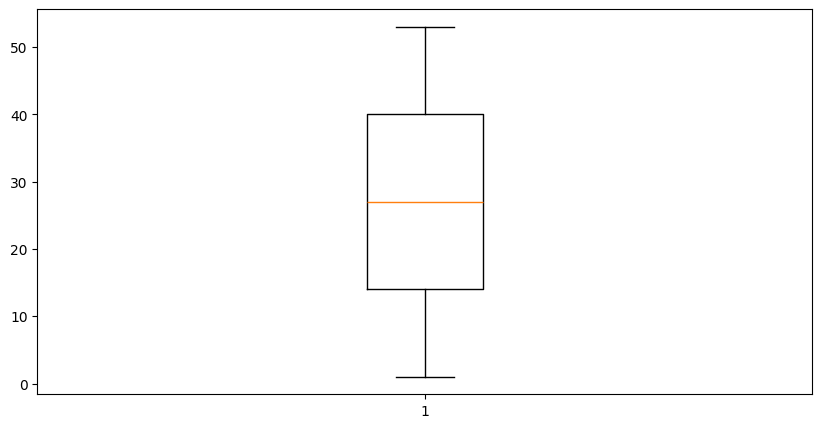

=== Processing column: case_count ===

----Checking outliers for column:---
 case_count
Number of outliers in case_count:  2220


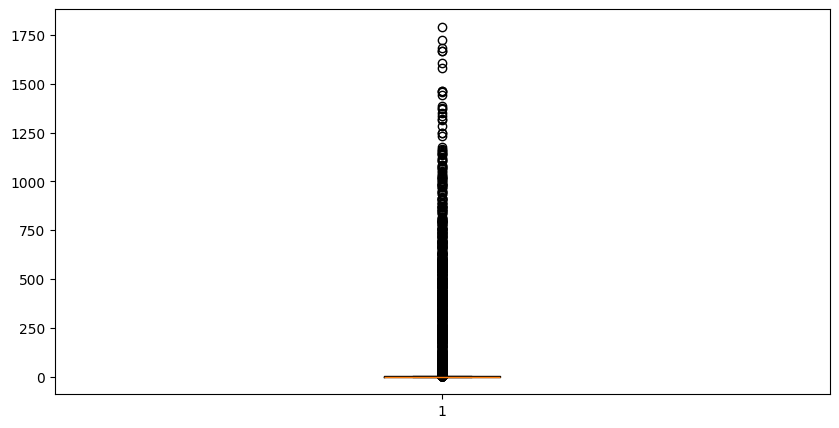


---Categorical Columns Analysis---


=== Processing column: epidemiological_week ===


=== Processing column: epidemiological_week ===

Total number of unique diseases: 470

All unique diseases:
1. 2012-W01
2. 2012-W02
3. 2012-W03
4. 2012-W04
5. 2012-W05
6. 2012-W06
7. 2012-W07
8. 2012-W08
9. 2012-W09
10. 2012-W10
11. 2012-W11
12. 2012-W12
13. 2012-W13
14. 2012-W14
15. 2012-W15
16. 2012-W16
17. 2012-W17
18. 2012-W18
19. 2012-W19
20. 2012-W20
21. 2012-W21
22. 2012-W22
23. 2012-W23
24. 2012-W24
25. 2012-W25
26. 2012-W26
27. 2012-W27
28. 2012-W28
29. 2012-W29
30. 2012-W30
31. 2012-W31
32. 2012-W32
33. 2012-W33
34. 2012-W34
35. 2012-W35
36. 2012-W36
37. 2012-W37
38. 2012-W38
39. 2012-W39
40. 2012-W40
41. 2012-W41
42. 2012-W42
43. 2012-W43
44. 2012-W44
45. 2012-W45
46. 2012-W46
47. 2012-W47
48. 2012-W48
49. 2012-W49
50. 2012-W50
51. 2012-W51
52. 2012-W52
53. 2013-W01
54. 2013-W02
55. 2013-W03
56. 2013-W04
57. 2013-W05
58. 2013-W06
59. 2013-W07
60. 2013-W08
61. 2013-W09
62. 2013-W10
63. 201

In [252]:
# check AI processes dataset
AI_df_no_duplicates = check_df_val(AI_df)

## Data Cleaning
- for names that refers to the same virus but with different spelling according to above analysis

In [253]:
df_no_duplicates = df_no_duplicates.with_columns(pl.col("disease").map_dict({"Nipah" : "Nipah virus infection", "Zika" : "Zika Virus Infection", "HFMD" : "Hand, Foot Mouth Disease"}, default=pl.first()))
AI_df_no_duplicates = AI_df_no_duplicates.with_columns(pl.col("disease_name").map_dict({"Nipah" : "Nipah virus infection", "Zika" : "Zika Virus Infection", "HFMD" : "Hand, Foot Mouth Disease"}, default=pl.first()))

In [254]:
df

epi_week,disease,no._of_cases
str,str,i64
"""2012-W01""","""Acute Viral he…",0
"""2012-W01""","""Acute Viral he…",0
"""2012-W01""","""Avian Influenz…",0
"""2012-W01""","""Campylobactere…",6
"""2012-W01""","""Chikungunya Fe…",0
"""2012-W01""","""Cholera""",0
"""2012-W01""","""Dengue Fever""",74
"""2012-W01""","""Dengue Haemorr…",0
"""2012-W01""","""Diphtheria""",0


In [255]:
check_categorical_values(df_no_duplicates, "disease")
check_categorical_values(AI_df_no_duplicates, "disease_name")


=== Processing column: disease ===

Total number of unique diseases: 42

All unique diseases:
1. Acute Viral Hepatitis A
2. Acute Viral Hepatitis E
3. Acute Viral hepatitis B
4. Acute Viral hepatitis C
5. Avian Influenza
6. Botulism
7. Campylobacter enteritis
8. Campylobacterenterosis
9. Chikungunya
10. Chikungunya Fever
11. Cholera
12. Dengue Fever
13. Dengue Haemorrhagic Fever
14. Diphtheria
15. Ebola Virus Disease
16. Encephalitis
17. Haemophilus influenzae type b
18. Hand, Foot Mouth Disease
19. Japanese Encephalitis
20. Legionellosis
21. Leptospirosis
22. Malaria
23. Measles
24. Melioidosis
25. Meningococcal Infection
26. Mumps
27. Murine Typhus
28. Nipah virus infection
29. Paratyphoid
30. Pertussis
31. Plague
32. Pneumococcal Disease (invasive)
33. Poliomyelitis
34. Rubella
35. SARS
36. Salmonellosis(non-enteric fevers)
37. Tetanus
38. Typhoid
39. Viral Hepatitis A
40. Viral Hepatitis E
41. Yellow Fever
42. Zika Virus Infection

Value counts:
 shape: (42, 2)
┌──────────────────

### Cleaning up date time column

In [256]:
def clean_timestamp(df: pl.DataFrame, col: str) -> pl.DataFrame:
    """
    Function to clean timestamp column to standard format YYYY-MM-DD and Week Column
    Args:
        df: polars dataframe
        col: column name of timestamp
    Outputs:
        df: pl.DataFrame with cleaned timestamp column
    """
    df = df.with_columns(
    pl.col(col)
        .str.split("-")
        .cast(pl.List(pl.Utf8))   # split produces List[str]
        .alias(f"{col}_split")
    )
    
    print(df.head())
    df = df.with_columns(
        [
            #from split get the date portion
            pl.col("epi_week_split")
            .list
            .get(0)
            .cast(pl.Int32)
            .alias("date"),

            # from split get the week portion and typecast int32
            pl.col("epi_week_split")
            .list.get(1)
            .str.extract(r"(\d+)")
            .cast(pl.Int32)
            .alias("week")

        ]
    ).drop(f"{col}_split") #drop the split column

    return df

In [257]:
clean_timestamp(df_no_duplicates, "epi_week")

shape: (5, 4)
┌──────────┬───────────────────────┬──────────────┬─────────────────┐
│ epi_week ┆ disease               ┆ no._of_cases ┆ epi_week_split  │
│ ---      ┆ ---                   ┆ ---          ┆ ---             │
│ str      ┆ str                   ┆ i64          ┆ list[str]       │
╞══════════╪═══════════════════════╪══════════════╪═════════════════╡
│ 2012-W01 ┆ Avian Influenza       ┆ 0            ┆ ["2012", "W01"] │
│ 2012-W01 ┆ Nipah virus infection ┆ 0            ┆ ["2012", "W01"] │
│ 2012-W01 ┆ Plague                ┆ 0            ┆ ["2012", "W01"] │
│ 2012-W01 ┆ Poliomyelitis         ┆ 0            ┆ ["2012", "W01"] │
│ 2012-W01 ┆ Viral Hepatitis A     ┆ 1            ┆ ["2012", "W01"] │
└──────────┴───────────────────────┴──────────────┴─────────────────┘


epi_week,disease,no._of_cases,date,week
str,str,i64,i32,i32
"""2012-W01""","""Avian Influenz…",0,2012,1
"""2012-W01""","""Nipah virus in…",0,2012,1
"""2012-W01""","""Plague""",0,2012,1
"""2012-W01""","""Poliomyelitis""",0,2012,1
"""2012-W01""","""Viral Hepatiti…",1,2012,1
"""2012-W01""","""Viral Hepatiti…",3,2012,1
"""2012-W02""","""Acute Viral he…",0,2012,2
"""2012-W02""","""Avian Influenz…",0,2012,2
"""2012-W02""","""Dengue Haemorr…",2,2012,2


In [258]:
df_no_duplicates.write_csv("../datasets/weekly-infectious-disease-bulletin-cases-cleaned.csv")
AI_df_no_duplicates.write_parquet("../datasets/weekly-infectious-disease-bulletin-cases-AI-cleaned.parquet")
